In [6]:
import gzip, csv, json, re, itertools, random, time
from pathlib import Path

import torch
from torch.utils.data import DataLoader

from sentence_transformers import models, SentenceTransformer, InputExample, losses, util

import numpy as np
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DATA_DIR      = Path("data/GSEA/external_gene_data/store!")
OUTPUT_DIR    = Path("output/model")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

GENE_FILE     = DATA_DIR / "rat_genes_consolidated.txt.gz"
PATHWAY_FILE  = DATA_DIR / "wikipathways_synonyms_Rattus_norvegicus.gmt.gz"

TRAIN_JSONL   = OUTPUT_DIR / "train.jsonl"
VAL_JSONL     = OUTPUT_DIR / "val.jsonl"
TEST_JSONL    = OUTPUT_DIR / "test.jsonl"

BASE_MODEL    = "michiyasunaga/BioLinkBERT-large"
OUTPUT_FOLDER = OUTPUT_DIR / "biolinkbert-large-simcse-rat"
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE     = 256
EPOCHS         = 6
LEARNING_RATE  = 3e-5
WARMUP_RATIO   = 0.1


In [7]:
def add_pairs(pairs, texts):
    """Add all unique 2-combinations from texts as positive pairs."""
    texts = [t.strip() for t in texts if t and str(t).strip()]
    for a, b in itertools.combinations(set(texts), 2):
        pairs.append((a, b, 1))    # label=1 for positives

pos_pairs = []
with gzip.open(GENE_FILE, "rt") as fh:
    rdr = csv.DictReader(fh)
    for row in rdr:
        add_pairs(pos_pairs, [
            row["Gene stable ID"],
            row["Gene name"],
            row["Gene description"]
        ])

bracket_re = re.compile(r"\[([^\]]+)\]")
with gzip.open(PATHWAY_FILE, "rt") as fh:
    for line in fh:
        if not line.strip():
            continue
        pathway = re.sub(r"\s+", " ", line.split("\t")[0]).strip()
        for grp in bracket_re.findall(line):
            syns = [g.strip() for g in grp.split(",") if g.strip()]
            add_pairs(pos_pairs, syns)
            for s in syns:
                pos_pairs.append((pathway, s, 1))

all_texts = list({t for a, b, _ in pos_pairs for t in (a, b)})

pos_set = {(a, b) for a, b, _ in pos_pairs}

neg_pairs = set()
while len(neg_pairs) < len(pos_pairs):
    a, b = random.sample(all_texts, 2)
    if (a, b) in pos_set or (b, a) in pos_set:
        continue
    if (a, b) in neg_pairs or (b, a) in neg_pairs:
        continue
    neg_pairs.add((a, b))
neg_pairs = [(a, b, 0) for a, b in neg_pairs]  # label=0

all_pairs = pos_pairs + neg_pairs
random.shuffle(all_pairs)

N      = len(all_pairs)
n_test = int(0.1 * N)
n_rem  = N - n_test
n_val  = n_rem // 9
n_train= n_rem - n_val

splits = {
    "train": all_pairs[n_test + n_val:],
    "val":   all_pairs[n_test: n_test + n_val],
    "test":  all_pairs[:n_test],
}

for name, path in [("train", TRAIN_JSONL),
                   ("val",   VAL_JSONL),
                   ("test",  TEST_JSONL)]:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for a, b, label in splits[name]:
            json.dump({"text1": a, "text2": b, "label": label}, f, ensure_ascii=False)
            f.write("\n")
print(f"✅ Train={len(splits['train']):,}  Val={len(splits['val']):,}  Test={len(splits['test']):,}")

✅ Train=194,454  Val=24,306  Test=24,306


In [8]:
train_data = [json.loads(l) for l in TRAIN_JSONL.open("r", encoding="utf-8")]
val_data   = [json.loads(l) for l in VAL_JSONL.open("r", encoding="utf-8")]

train_examples = [
    InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
    for d in train_data
]
val_examples = [
    InputExample(texts=[d["text1"], d["text2"]], label=d["label"])
    for d in val_data
]

train_loader = DataLoader(train_examples,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True)
val_loader   = DataLoader(val_examples,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          drop_last=False)

# Build SBERT model
word_model = models.Transformer(BASE_MODEL, max_seq_length=128)
word_model.auto_model.gradient_checkpointing_enable()
pooling = models.Pooling(word_model.get_word_embedding_dimension(),
                         pooling_mode_mean_tokens=True)
model = SentenceTransformer(modules=[word_model, pooling], device=DEVICE)

loss = losses.ContrastiveLoss(model=model)

# Train
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

model.fit(
    train_objectives=[(train_loader, loss)],
    epochs=EPOCHS,
    optimizer_params={"lr": LEARNING_RATE},
    warmup_steps=warmup_steps,
    output_path=str(OUTPUT_FOLDER),
    show_progress_bar=True
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.029500
1000,0.020500
1500,0.018500
2000,0.018000
2500,0.017400
3000,0.017000
3500,0.016500
4000,0.016300
4500,0.016100


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Saved plot to output\model\PNG\base_6_epochs.png


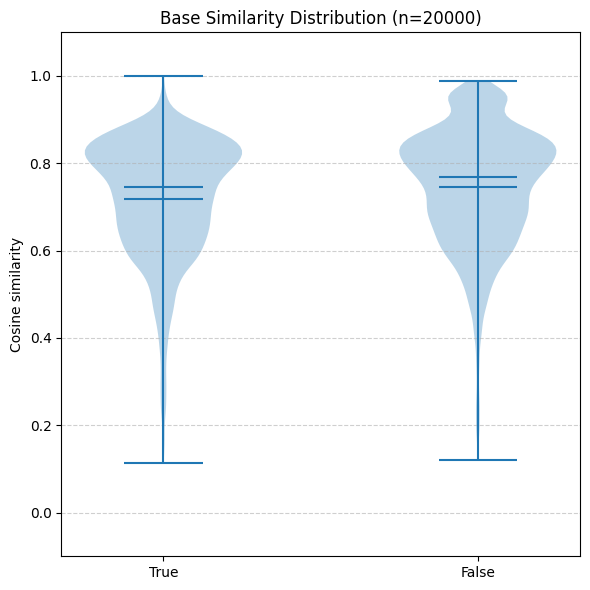

Saved plot to output\model\PNG\fine-tuned_6_epochs.png


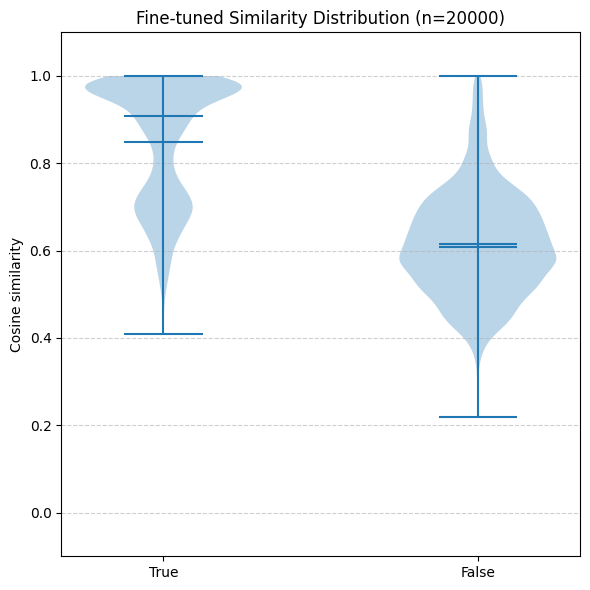

In [14]:
test_data = [json.loads(l) for l in TEST_JSONL.open("r", encoding="utf-8")]
sample_size = min(20000, len(test_data))
sampled = random.sample(test_data, sample_size)
t1     = [d['text1'] for d in sampled]
t2     = [d['text2'] for d in sampled]
labels = np.array([d['label'] for d in sampled])

word_model_base = models.Transformer(BASE_MODEL, max_seq_length=128)
word_model_base.auto_model.gradient_checkpointing_enable()
pool_base = models.Pooling(word_model_base.get_word_embedding_dimension(),
                           pooling_mode_mean_tokens=True)
base_model = SentenceTransformer(modules=[word_model_base, pool_base], device=DEVICE)
fine_model = SentenceTransformer(str(OUTPUT_FOLDER), device=DEVICE)

batch_size_encode = 128
emb_b1 = base_model.encode(t1, batch_size=batch_size_encode,
                           convert_to_tensor=True, show_progress_bar=True)
emb_b2 = base_model.encode(t2, batch_size=batch_size_encode,
                           convert_to_tensor=True, show_progress_bar=False)
emb_f1 = fine_model.encode(t1, batch_size=batch_size_encode,
                           convert_to_tensor=True, show_progress_bar=False)
emb_f2 = fine_model.encode(t2, batch_size=batch_size_encode,
                           convert_to_tensor=True, show_progress_bar=False)

sims = {
    'Base':       util.cos_sim(emb_b1, emb_b2).diag().cpu().numpy(),
    'Fine-tuned': util.cos_sim(emb_f1, emb_f2).diag().cpu().numpy()
}

for name, arr in sims.items():
    true_vals  = arr[labels == 1]
    false_vals = arr[labels == 0]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.violinplot([true_vals, false_vals], showmeans=True, showmedians=True)
    ax.set_title(f"{name} Similarity Distribution (n={sample_size})")
    ax.set_xticks([1, 2]); ax.set_xticklabels(["True", "False"])
    ax.set_ylabel("Cosine similarity")
    ax.grid(True, axis="y", linestyle="--", alpha=0.6)
    ax.set_ylim(-0.1, 1.1)
    plt.tight_layout()
    # Save figure using the number of epochs in filename
    save_path = OUTPUT_DIR/ "PNG" / f"{name.lower()}_{EPOCHS}_epochs.png"
    fig.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()

In [12]:
BASE_MODEL

'michiyasunaga/BioLinkBERT-large'

In [ ]:
from huggingface_hub import HfApi
import os
api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path="./output/model/biolinkbert-large-simcse-rat",
    repo_id="mghuibregtse/biolinkbert-large-simcse-rat",
    repo_type="model",
)


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]